# Step 1: Experiment in a notebook
<div class="alert alert-warning"> This notebook has been last tested on a SageMaker Studio JupyterLab instance using the <code>SageMaker Distribution Image 3.0.1</code> and with the SageMaker Python SDK version <code>2.245.0</code></div>

In this step you run data processing and model training and evaluation in the notebook locally. You don't use `sagemaker` or `boto3` packages.

**From idea to production in six steps:**
||||
|---|---|---|
|1. |Experiment in a notebook |**<<<< YOU ARE HERE**|
|2. |Scale with SageMaker AI processing jobs and SageMaker SDK ||
|3. |Operationalize with ML pipeline, model registry, and feature store ||
|4. |Add a model building CI/CD pipeline ||
|5. |Add a model deployment pipeline ||
|6. |Add model and data monitoring ||

<div class="alert alert-info"> Make sure you using <code>Python 3</code> kernel in JupyterLab for this notebook.</div>

In [ ]:
# We use the opensource xgboost algorithm to implement the model
%pip install -q xgboost

In [ ]:
# Need to install mlflow so this notebook can run standalone as a SageMaker job
%pip install --upgrade mlflow sagemaker-mlflow

In [1]:
import pandas as pd
import numpy as np 
import json
import joblib
import xgboost as xgb
import sagemaker
import boto3
import os
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
from mlflow.models import infer_signature
from time import gmtime, strftime, sleep
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

sagemaker.__version__

/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Fetched defaults config from location: /home/sagemaker-user/.config/sagemaker/config.yaml


'2.239.0'

In [2]:
%store -r 

%store

try:
    initialized
except NameError:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN 00-start-here notebook   ")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++")
    user_profile_name = sagemaker.get_execution_role()

Stored variables and their in-db values:
baseline_s3_url                         -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
bucket_name                             -> 'sagemaker-us-east-1-906545278380'
bucket_prefix                           -> 'from-idea-to-prod/xgboost'
dataset_feature_group_name              -> 'from-idea-to-prod-20-12-09-53'
dataset_file_local_path                 -> 'data/bank-additional/bank-additional-full.csv'
domain_id                               -> 'd-igloxuzrs3z2'
evaluation_s3_url                       -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
experiment_name                         -> 'from-idea-to-prod-experiment-19-17-15-04'
feature_store_bucket_prefix             -> 'from-idea-to-prod/feature-store'
initialized                             -> True
input_s3_url                            -> 's3://sagemaker-us-east-1-906545278380/from-idea-t
mlflow_arn                              -> 'arn:aws:sagemaker:us-east-1:906545278380:mlflow

In [3]:
target_col = "y"

In [4]:
%store target_col

Stored 'target_col' (str)


In [5]:
session = sagemaker.Session()
sm = session.sagemaker_client

## Load data
The following cell is tagged with `parameters` as the cell tag to enable parametrization for headless execution of the notebook as [SageMaker Notebook-based workflow](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run.html). Refer to the section **Run the notebook as a SageMaker job** for details and an example. Ignore this for now.

In [6]:
# This cell is tagged with `parameters` tag and will be overwritten if the notebook executed headlessly
file_source = "local"
file_name = "bank-additional-full.csv"
input_path = "./data/bank-additional" 
output_path = "./data"

In [7]:
# If run the notebook as a job, non-interactivel or headlessly, the notebook cannot access the JupyterLab EBS volume, download the dataset from S3 instead
# See the section "Run the notebook as a SageMaker job" for more details
if file_source != "local":
    session.download_data(
        path=os.path.join(input_path, ""), 
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input/{file_name}"
    )

## EDA
Let's do some explotary data analysis on this dataset.

In [8]:
df_data = pd.read_csv(os.path.join(input_path, file_name), sep=";")

pd.set_option("display.max_columns", 500)  # View all of the columns
df_data  # show first 5 and last 5 rows of the dataframe

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [9]:
# see column metadata
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
# see column statistics
df_data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


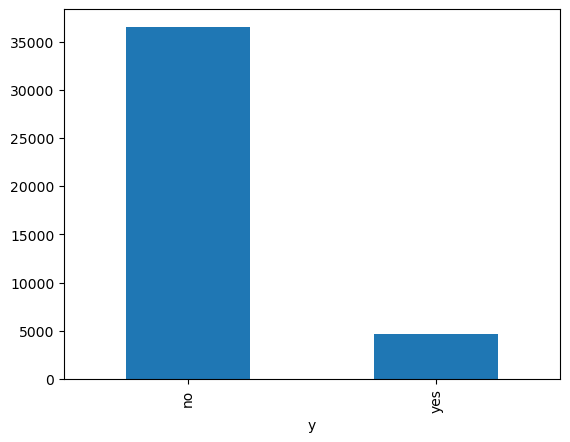

In [11]:
# see target distribution
df_data[target_col].value_counts().plot.bar()

plt.show()

In [12]:
# see if there are any missing values
df_data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

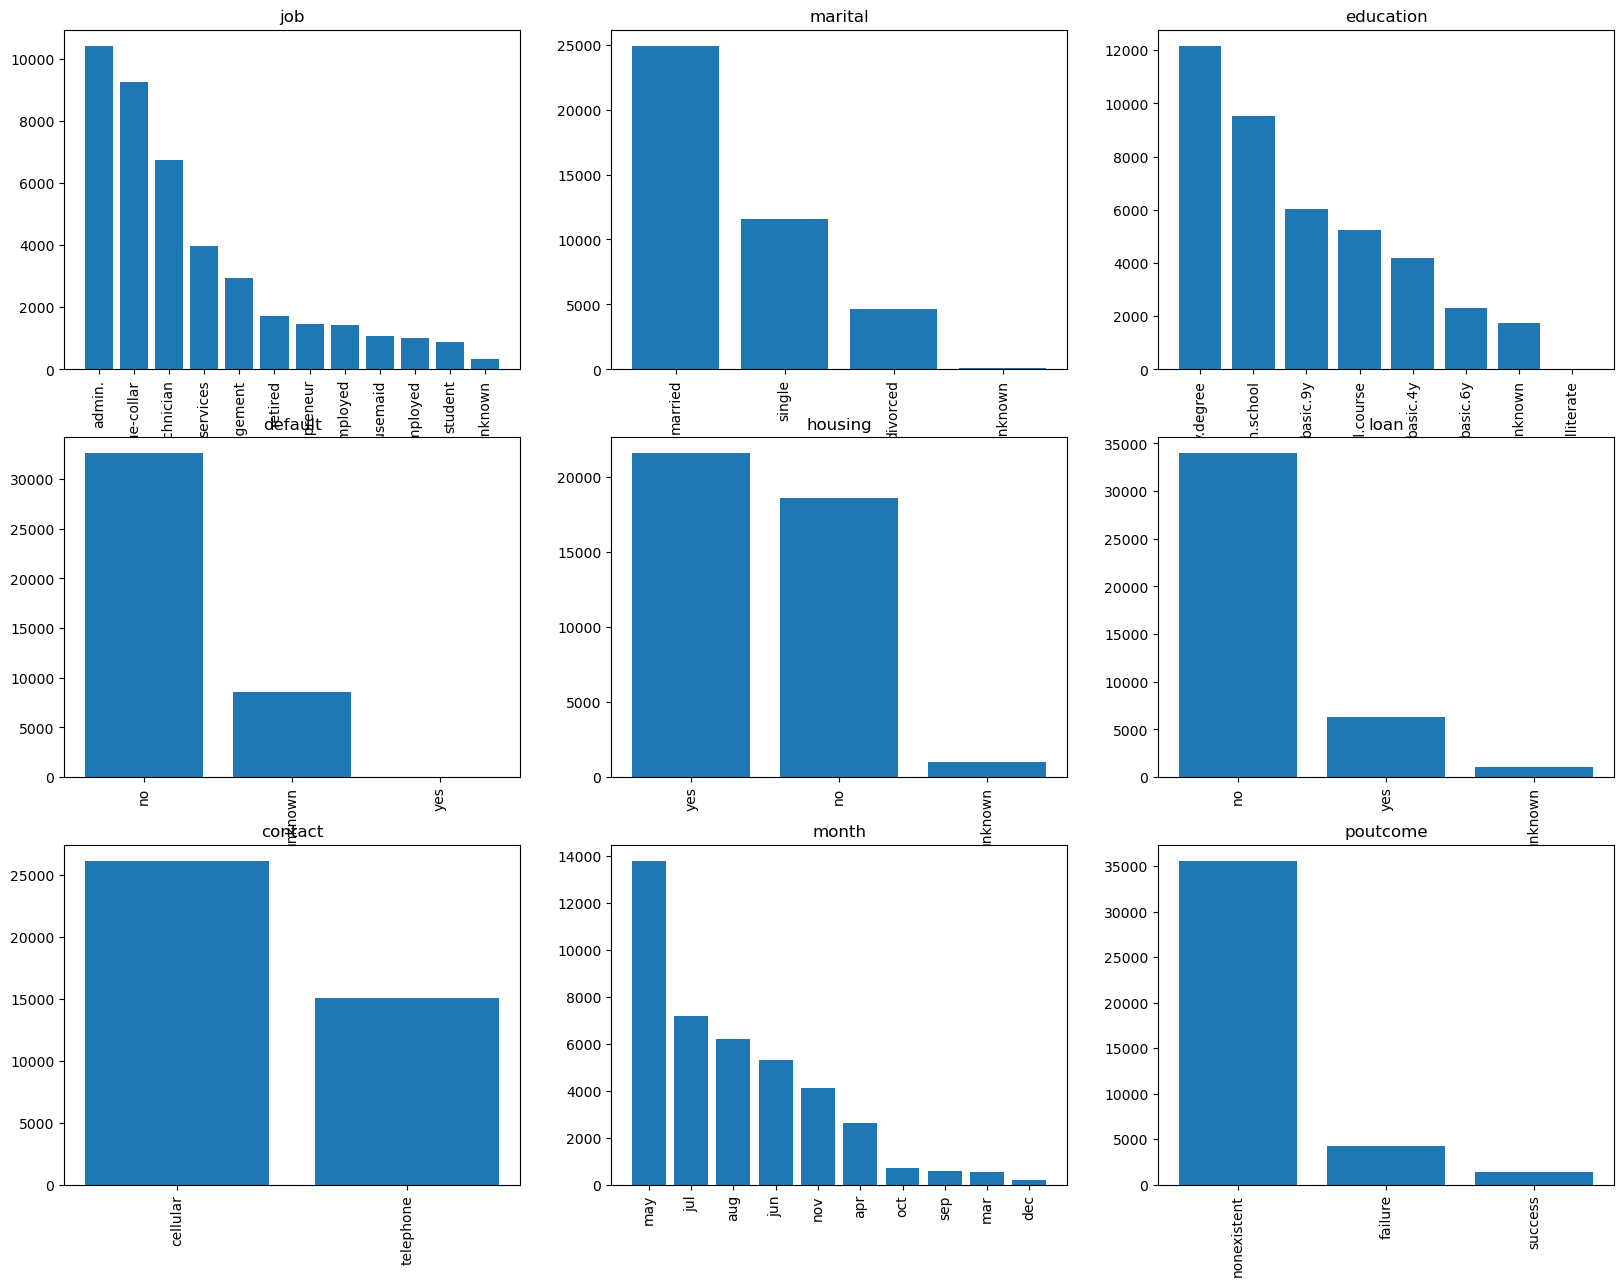

In [13]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df_data[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

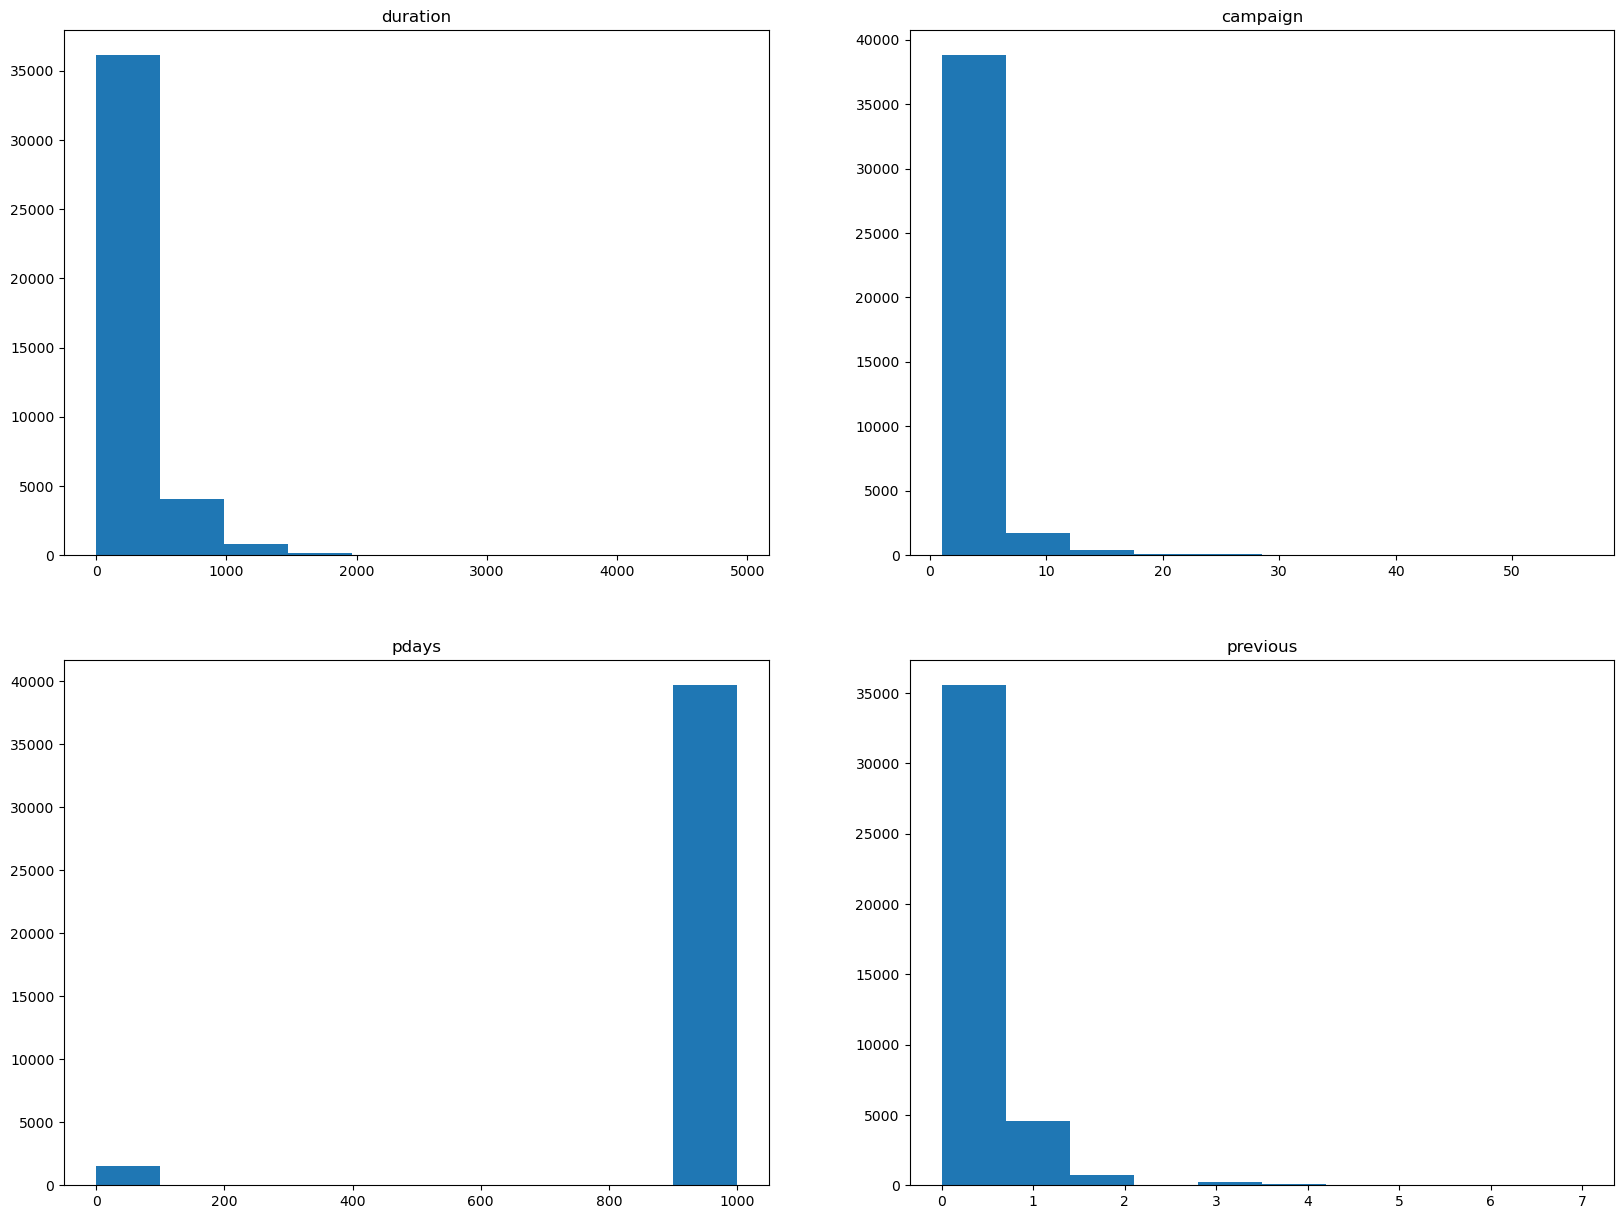

In [14]:
num_columns = ['duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 2, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 2
    trace_y = counter % 2
    
    axs[trace_x, trace_y].hist(df_data[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

<Axes: title={'center': 'Marital status and deposit'}, xlabel='marital'>

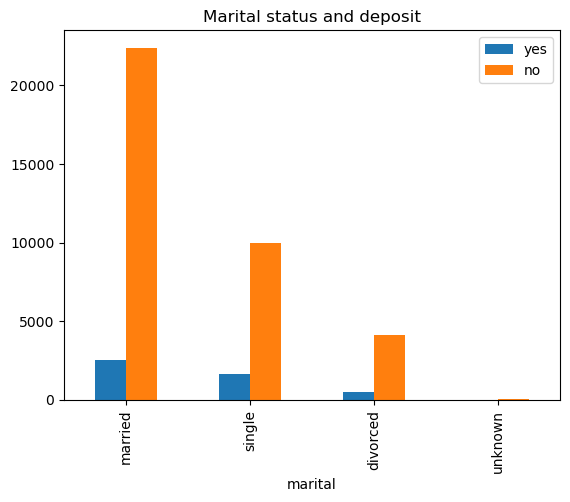

In [15]:
j_df = pd.DataFrame()

j_df['yes'] = df_data[df_data[target_col] == 'yes']['marital'].value_counts()
j_df['no'] = df_data[df_data[target_col] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')

## Tracking experiments with SageMaker and MLflow integration
You can [manage machine learning experiments using Amazon SageMaker with MLflow](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow.html) and use full functionality of MLflow with a central managed MLflow server.

[MLflow tracking](https://mlflow.org/docs/latest/tracking.html) allows automatically track the inputs, parameters, configurations, and models of your iterations as `experiments` and `runs`. See [MLflow concepts](https://mlflow.org/docs/latest/tracking.html#concepts) to understand how runs and experiments are organized.

In [16]:
if file_source == "local":
    # Check that the MLflow server is in the status 'Created'
    sm = boto3.client("sagemaker")
    
    while sm.describe_mlflow_tracking_server(TrackingServerName=mlflow_name)['TrackingServerStatus'] != 'Created':
        print(f"The MLflow server {mlflow_name} is not in the status 'Created'")
        sleep(30)
    else:
        print(f"Using server {mlflow_name}")

Using server test-mlflow


In [17]:
mlflow.set_tracking_uri(mlflow_arn)

In [18]:
experiment_suffix = strftime('%d-%H-%M-%S', gmtime())
experiment_name = f"from-idea-to-prod-experiment-{experiment_suffix}"
registered_model_name = f"from-idea-to-prod-experiment-model-{experiment_suffix}"

In [19]:
%store experiment_name

Stored 'experiment_name' (str)


In [20]:
experiment = mlflow.set_experiment(experiment_name=experiment_name)

2025/02/11 21:33:07 INFO mlflow.tracking.fluent: Experiment with name 'from-idea-to-prod-experiment-11-21-33-07' does not exist. Creating a new experiment.


## Feature engineering

As an example, the processing script implements the following feature engineering:
1. Create a new column called `no_previous_contact`. Set value to `1` when `pdays` is `999` and `0` otherwise
1. Generate a new column to show whether the customer is working based on `job` column
1. Remove the economic features from the dataset as they would need to be forecasted with high precision to be used as features during inference time
1. Remove `duration` as it is not know before a call is performed
1. Convert categorical variables to numeric using **one hot encoding**
1. Move the target column `y` to the front

In real world you implement additional processing, data quality handling, and feature engineering. You also go via multiple "try & fail" iterations.

In [21]:
# Indicator variable to capture when pdays takes a value of 999
df_data["no_previous_contact"] = np.where(df_data["pdays"] == 999, 1, 0)

# Indicator for individuals not actively employed
df_data["not_working"] = np.where(
    np.in1d(df_data["job"], ["student", "retired", "unemployed"]), 1, 0
)

# remove unnecessary data
df_model_data = df_data.drop(
    ["duration", "emp.var.rate", "cons.price.idx", "cons.conf.idx", "euribor3m", "nr.employed"],
    axis=1,
)


bins = [18, 30, 40, 50, 60, 70, 90]
labels = ['18-29', '30-39', '40-49', '50-59', '60-69', '70-plus']

df_model_data['age_range'] = pd.cut(df_model_data.age, bins, labels=labels, include_lowest=True)
df_model_data = pd.concat([df_model_data, pd.get_dummies(df_model_data['age_range'], prefix='age', dtype=int)], axis=1)
df_model_data.drop('age', axis=1, inplace=True)
df_model_data.drop('age_range', axis=1, inplace=True)

scaled_features = ['pdays', 'previous', 'campaign']
df_model_data[scaled_features] = MinMaxScaler().fit_transform(df_model_data[scaled_features])

df_model_data = pd.get_dummies(df_model_data, dtype=int)  # Convert categorical variables to sets of indicators

# Replace "y_no" and "y_yes" with a single label column, and bring it to the front:
df_model_data = pd.concat(
    [
        df_model_data["y_yes"].rename(target_col),
        df_model_data.drop(["y_no", "y_yes"], axis=1),
    ],
    axis=1,
)

In [22]:
df_model_data

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-plus,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0.000000,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
1,0,0.000000,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,0,0.000000,1.0,0.000000,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0.000000,1.0,0.000000,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0.000000,1.0,0.000000,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,1,0.000000,1.0,0.000000,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41184,0,0.000000,1.0,0.000000,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41185,0,0.018182,1.0,0.000000,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0
41186,1,0.000000,1.0,0.000000,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [23]:
df_model_data.describe()

,y,campaign,pdays,previous,no_previous_contact,not_working,age_18-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-plus,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,0.112654,0.028502,0.963439,0.024709,0.963217,0.087623,0.179130,0.397810,0.248616,0.152229,0.011848,0.010003,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,0.008012,0.111974,0.605225,0.280859,0.001942,0.101389,0.055647,0.146766,0.231014,0.000437,0.127294,0.295426,0.042027,0.791201,0.208726,0.000073,0.452122,0.024036,0.523842,0.824269,0.024036,0.151695,0.634748,0.365252,0.063902,0.149995,0.004419,0.174177,0.129115,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,0.316173,0.050364,0.187098,0.070700,0.188230,0.282749,0.383466,0.489452,0.432216,0.359247,0.108204,0.099514,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,0.089152,0.315339,0.488808,0.449424,0.044029,0.301846,0.229242,0.353877,0.421486,0.020901,0.333306,0.456239,0.200653,0.406455,0.406403,0.008534,0.497708,0.153163,0.499437,0.380596,0.153163,0.358729,0.481507,0.481507,0.244581,0.357071,0.066328,0.379266,0.335332,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

## Split data

[SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html#InputOutput-XGBoost) expects data in the libSVM or CSV formats, with:

- The target variable in the first column, and
- No header row

In [24]:
# Shuffle and splitting dataset
train_data, validation_data, test_data = np.split(
    df_model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(df_model_data)), int(0.9 * len(df_model_data))],
)

print(f"Data split > train:{train_data.shape} | validation:{validation_data.shape} | test:{test_data.shape}")

Data split > train:(28831, 65) | validation:(8238, 65) | test:(4119, 65)


/opt/conda/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [25]:
# Save data to Studio filesystem
train_data.to_csv(os.path.join(output_path, "train.csv"), index=False, header=False)
validation_data.to_csv(os.path.join(output_path, "validation.csv"), index=False, header=False)
test_data.to_csv(os.path.join(output_path, "test.csv"), index=False, header=False)

## Model training and validation

In [26]:
train_features = train_data.drop(target_col, axis=1)
train_label = pd.DataFrame(train_data[target_col])

In [27]:
dtrain = xgb.DMatrix(train_features, label=train_label)

In [28]:
hyperparams = {
                "max_depth": 5,
                "eta": 0.5,
                "alpha": 2.5,
                "objective": "binary:logistic",
                "subsample" : 0.8,
                "colsample_bytree" : 0.8,
                "min_child_weight" : 3
              }

num_boost_round = 150
nfold = 3
early_stopping_rounds = 10

First, train the model on `nfold` number of folds of the training dataset and run a cross-validation.

In [29]:
# Cross-validate on training data
cv_results = xgb.cv(
    params=hyperparams,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    nfold=nfold,
    early_stopping_rounds=early_stopping_rounds,
    metrics=["auc"],
    seed=10,
)

In [30]:
metrics_data = {
    "binary_classification_metrics": {
        "validation:auc": {
            "value": cv_results.iloc[-1]["test-auc-mean"],
            "standard_deviation": cv_results.iloc[-1]["test-auc-std"]
        },
        "train:auc": {
            "value": cv_results.iloc[-1]["train-auc-mean"],
            "standard_deviation": cv_results.iloc[-1]["train-auc-std"]
        },
    }
}

In [31]:
print(f"Cross-validated train-auc:{cv_results.iloc[-1]['train-auc-mean']:.2f}")
print(f"Cross-validated validation-auc:{cv_results.iloc[-1]['test-auc-mean']:.2f}")

Cross-validated train-auc:0.79
Cross-validated validation-auc:0.77


In [32]:
cv_results

,train-auc-mean,train-auc-std,test-auc-mean,test-auc-std
0,0.706051,0.003633,0.702311,0.004272
1,0.739844,0.003115,0.736423,0.008302
2,0.759104,0.002349,0.751833,0.009718
3,0.772488,0.005261,0.765497,0.008634
4,0.777498,0.005669,0.766645,0.009880
5,0.783590,0.005866,0.767316,0.009886
6,0.785391,0.006824,0.766873,0.010190
7,0.787827,0.006350,0.767751,0.008970


Now retrain the model on the full training dataset instead of splitting the training dataset across a number of folds. Use the test dataset for early stopping.

In [33]:
test_features = test_data.drop(target_col, axis=1)
test_label = pd.DataFrame(test_data[target_col])
dtest = xgb.DMatrix(test_features, label=test_label)

### Create an experiment run
Create a new run using the [`mlflow.start_run()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.start_run) API and call the [`log_params()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_params) and [`log_artifact()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_artifact) MLflow logging functions to record information into the run. Note that `mlflow.log_artifact()` uploads a local file to the MLflow artifact store under the S3 URI that you specified when you created the MLflow server.

You can also use [`log_input()`](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_input) method to persistently log a dataset to the MLflow artifact store.

In [34]:
run_suffix = strftime('%d-%H-%M-%S', gmtime())

with mlflow.start_run(
    run_name=f"feature-engineering-{run_suffix}",
    description="feature-engineering in the notebook 01 ideation") as run:
    mlflow.log_params(
        {
            "train": 0.7,
            "validate": 0.2,
            "test": 0.1
        }
    )
    # Log input dataset metadata and output
    mlflow.log_artifact(local_path=os.path.join(input_path, file_name))
    mlflow.log_artifact(local_path=os.path.join(output_path, "train.csv"))
    mlflow.log_artifact(local_path=os.path.join(output_path, "validation.csv"))
    mlflow.log_artifact(local_path=os.path.join(output_path, "test.csv"))

🏃 View run feature-engineering-11-21-33-25 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/38a32af5bfa248378467304a3b8ad943
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36


### Train a model
Use [MLflow model flavor](https://mlflow.org/docs/latest/python_api/index.html#python-api) and [logging functions](https://mlflow.org/docs/latest/tracking/tracking-api.html#tracking-logging-functions) to log parameters, model, model metrics, and various metadata in your experiment runs.

In [35]:
# in the production code you need to use the unique ids
run_suffix = strftime('%d-%H-%M-%S', gmtime())
max_metric = 0.0
best_model_run_id = 0

with mlflow.start_run(
    run_name=f"training-{run_suffix}",
    description=f"Fit estimator with different max_depth") as parent_run:
    mlflow.set_tags({'mlflow.user':user_profile_name})
    
    # Train the model for different max_depth values
    for i, d in enumerate([2, 5, 10, 15, 20]):
        hyperparams["max_depth"] = d
        print(f"Fit estimator with max_depth={d}")
    
        with mlflow.start_run(
            run_name=f"max_depth={d}",
            description=f"Fit estimator with max_depth={d}",
            nested=True) as child_run:
            mlflow.set_tags({'mlflow.user':user_profile_name})
            
            mlflow.xgboost.autolog(log_model_signatures=False, log_datasets=False)
            
            # Train the model
            model = xgb.train(
                params=hyperparams, 
                dtrain=dtrain, 
                evals = [(dtrain,'train'), (dtest,'eval')], 
                num_boost_round=num_boost_round, 
                early_stopping_rounds=early_stopping_rounds, 
                verbose_eval = 0
            )
    
            # Calculate metrics
            test_auc = roc_auc_score(test_label, model.predict(dtest))
            train_auc = roc_auc_score(train_label, model.predict(dtrain))
            
            # Log hyperparameters and metrics to the run
            mlflow.log_params(hyperparams)
            mlflow.log_metrics({"test_auc":test_auc, "train_auc":train_auc}, step=i)
    
            if test_auc > max_metric:
                best_model_run_id = child_run.info.run_id
                max_metric = test_auc
    
            print(f"Test AUC: {test_auc:.4f} | Train AUC: {train_auc:.4f}")

Fit estimator with max_depth=2


2025/02/11 21:33:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:33:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/11 21:33:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test AUC: 0.7739 | Train AUC: 0.7892
🏃 View run max_depth=2 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/4d8f01cbcc324315a515090708d065a5
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36
Fit estimator with max_depth=5


2025/02/11 21:33:35 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:33:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/11 21:33:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test AUC: 0.7722 | Train AUC: 0.8090
🏃 View run max_depth=5 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/d038b5d66a654aaba7750a374bd2498c
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36
Fit estimator with max_depth=10


2025/02/11 21:33:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:33:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/11 21:33:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test AUC: 0.7579 | Train AUC: 0.8513
🏃 View run max_depth=10 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/fcc593d41a3b486d8000b2a448d32e85
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36
Fit estimator with max_depth=15


2025/02/11 21:33:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:33:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/11 21:33:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test AUC: 0.7550 | Train AUC: 0.8763
🏃 View run max_depth=15 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/ad10f5a4acd34b3882f21b2657283fc6
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36
Fit estimator with max_depth=20


2025/02/11 21:33:49 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [21:33:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1737698414298/work/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/02/11 21:33:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Test AUC: 0.7574 | Train AUC: 0.8812
🏃 View run max_depth=20 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/851c11e93cf84953a6f0645ec17504f8
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36
🏃 View run training-11-21-33-27 at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36/runs/b6b61ef593734e60bd022a75eee708af
🧪 View experiment at: https://us-east-1.experiments.sagemaker.aws/#/experiments/36


### Register the model in the MLflow model registry
Use [MLflow model registry](https://mlflow.org/docs/latest/model-registry.html#adding-an-mlflow-model-to-the-model-registry) to register a model.
In this example we use [mlflow.register_model()](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.register_model) API to register the best model as a new version under the registered model name. `mlflow.register_model()` also automatically registers a model with the SageMaker Model Registry. When registering the MLflow model, a corresponding model package group and model package version are created in SageMaker.

In [36]:
model_uri = f"runs:/{best_model_run_id}/xgboost"
mv = mlflow.register_model(model_uri, registered_model_name)

Successfully registered model 'from-idea-to-prod-experiment-model-11-21-33-07'.
2025/02/11 21:34:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: from-idea-to-prod-experiment-model-11-21-33-07, version 1
Created version '1' of model 'from-idea-to-prod-experiment-model-11-21-33-07'.


## Explore experiments with the MLflow UI
As a starting point, you can access all experiments in the Studio UI in the **SageMaker Home** > **Experiments** widget. 

For example, select your experiment:

![](img/experiments-studio.png)

The experiment is opened in the MLflow UI in a new browser window:

![](img/experiment-mlflow.png)

You can select runs you would like to analyse and click **Compare**. In Comparing window you can analyze metrics and parameters logged in your runs:

![](img/comparing-runs.png)

Change to the **Models** to see the registered models and all versions:

![](img/models-mlflow.png)

Refer to the [Announcing the general availability of fully managed MLflow on Amazon SageMaker](https://aws.amazon.com/blogs/aws/manage-ml-and-generative-ai-experiments-using-amazon-sagemaker-with-mlflow/) launch blog post and [Developer Guide](https://docs.aws.amazon.com/sagemaker/latest/dg/mlflow-track-experiments.html) for more examples and details on SageMaker Experiments with MLflow.

## Optional: Run the notebook as a SageMaker job
Sometimes there are scenarios in which you might want to run your notebooks as a non-interactive, scheduled jobs. Studio provides fast and simple tools built from the existing Amazon EventBridge, SageMaker Training and SageMaker Pipelines services to help you schedule your notebook jobs interactively. You don’t have to craft your own custom solution or enlist features from other services that may require additional overhead in time and costs to deploy.

You can run your notebook as a SageMaker job on-demand on based on any schedule you choose. You can also run multiple notebooks in parallel, and parametrize cells in your notebooks.

### Adapt the notebook to run headlessly
A headless notebook runs in a shell outside of the Studio environment. Therefore, your code in the notebook cannot depend on or access the Studio local storage, environment variables, or Python store. You must accordingly change any code which uses the local Studio environment.

### How to run
Follow the instructions in [Notebook-based Workflows](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run.html) in the Developer Guide to run this notebook in non-interactive mode as a SageMaker job:
1. [Configure](https://docs.aws.amazon.com/sagemaker/latest/dg/scheduled-notebook-policies.html) the trust policy and additional IAM permissions for the Studio execution role. If you run this notebook in the domain in the AWS-preprovisioned account, the required permissions are automatically deployed
2. Provide the parameters as specified below
3. Run the notebook on-demand or schedule a job
4. Explore the results

### Set parameters

In [37]:
# output the name of the S3 bucket used by SageMaker – you need this value as bucket_name parameter
print(bucket_name)

sagemaker-us-east-1-906545278380


In [38]:
# output MLflow server ARN
print(mlflow_arn)

arn:aws:sagemaker:us-east-1:906545278380:mlflow-tracking-server/test-mlflow


In [39]:
# If running interactively, upload data to S3 to have it here for a headless run
if file_source == 'local':
    input_s3_url = session.upload_data(
        path=os.path.join(input_path, file_name),
        bucket=bucket_name,
        key_prefix=f"{bucket_prefix}/input"
    )
    
    print(input_s3_url)

s3://sagemaker-us-east-1-906545278380/from-idea-to-prod/xgboost/input/bank-additional-full.csv


To parameterize your notebook, you [set](https://docs.aws.amazon.com/sagemaker/latest/dg/notebook-auto-run-troubleshoot-override.html) a tag `parameters` on a single cell in your notebook that marks it as the "parameter cell". SageMaker notebook execution will insert a new generated cell directly after that cell tagged with `parameters` at runtime. The generated cell will have code which sets the parameters with values you specifiy when you start an execution job.

The notebook execution job has no access to the JupyterLab EBS volume. Any data you need to pass to the notebook must be copied to an S3 bucket, where the notebook can access it.

To run this notebook as a SageMaker job, choose the **Create a notebook job** icon in the notebook taskbar: 

![](img/notebook-as-sm-job-run.png)

Set the following parameters to specified values in **Parameter** section of the form:

![](img/notebook-as-sm-job-parameters.png)

Parameters and values:

```
mlflow_arn = <SET TO YOUR MLFLOW SERVER ARN>
file_source = S3
input_path = /opt/ml/input/data/sagemaker_headless_execution 
output_path = /opt/ml/output/data
bucket_name = <SET TO YOUR SAGEMAKER BUCKET NAME>
bucket_prefix = from-idea-to-prod/xgboost
```

Select **Run now** or **Run on a schedule** and choose **Create**.

You can also [create a notebook job programmatically with SageMaker Python SDK](https://docs.aws.amazon.com/sagemaker/latest/dg/create-notebook-auto-run-sdk.html). 

---

## Continue with the step 2
open the step 2 [notebook](02-sagemaker-containers.ipynb).

## Further development ideas for your real-world projects
- Try different models, for example some of the [SageMaker built-in algorithms](https://docs.aws.amazon.com/sagemaker/latest/dg/algos.html), such as [CatBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/catboost.html), [AutoGluon-Tabular](https://docs.aws.amazon.com/sagemaker/latest/dg/autogluon-tabular.html), or [Linear Learner Algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html)
- Try [SageMaker Autopilot](https://aws.amazon.com/sagemaker/autopilot/) to automatically explore different solutions to find the best model. Refer to this hands-on tutorial: [Automatically Create Machine Learning Models](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-automatically-create-models/)
- Implement batch inference using [SageMaker Batch Transform](https://docs.aws.amazon.com/sagemaker/latest/dg/batch-transform.html)

## Additional resources
- [Build and Train a Machine Learning Model Locally](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-build-model-locally/)
- [Amazon SageMaker XGBoost algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)
- [Automatically Create Machine Learning Models](https://aws.amazon.com/getting-started/hands-on/machine-learning-tutorial-automatically-create-models/)
- [Operationalize your Amazon SageMaker Studio notebooks as scheduled notebook jobs](https://aws.amazon.com/blogs/machine-learning/operationalize-your-amazon-sagemaker-studio-notebooks-as-scheduled-notebook-jobs/)
- [Dataset transformations](https://scikit-learn.org/stable/data_transforms.html)
- [Extracting, transforming and selecting features](https://spark.apache.org/docs/latest/ml-features.html)

# Shutdown kernel

In [ ]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>